In [1]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

Using TensorFlow backend.


In [2]:
driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head(10))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg
5    p002        c0   img_3370.jpg
6    p002        c0  img_67639.jpg
7    p002        c0  img_58560.jpg
8    p002        c0  img_35779.jpg
9    p002        c0  img_10012.jpg


In [3]:
train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("C:\\Users\\Sridhar\\Downloads\\state-farm-distracted-driver-detection\\imgs\\train\\c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "C:\\Users\\Sridhar\\Downloads\\state-farm-distracted-driver-detection\\imgs\\train\\c"+str(i)+"\\"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [4]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [5]:
driv_selected = ['p050', 'p015', 'p022', 'p056','p075','p002','p049','p039']

In [6]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

15531 6893
15531 6893


In [7]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)

(15531, 224, 224, 3)


In [8]:
## Defining the input

from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [9]:
#Use the generated model 
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(input = vgg16_input, output = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 5)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 5, callbacks=[checkpointer, earlystopper],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3107/3106 [==============================] - 22172s 7s/step - loss: 14.4748 - accuracy: 0.1017 - val_loss: 14.3901 - val_accuracy: 0.1072

Epoch 00001: val_loss improved from inf to 14.39007, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 2/10
3107/3106 [==============================] - 21929s 7s/step - loss: 14.4965 - accuracy: 0.1003 - val_loss: 14.3877 - val_accuracy: 0.1074

Epoch 00002: val_loss improved from 14.39007 to 14.38773, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 3/10
3107/3106 [==============================] - 21267s 7s/step - loss: 14.4726 - accuracy: 0.1021 - val_loss: 14.3877 - val_accuracy: 0.1074

Epoch 00003: val_loss did not improve from 14.38773
Epoch 4/10
3107/3106 [==============================] - 20594s 7s/step - loss: 14.4684 - accuracy: 0.1021 - val_loss: 14.3877 - val_accuracy: 0.1074

Epoch 00004: val_loss did not improve from 14.38773
Epoch 5/10
3107/3106 [===================

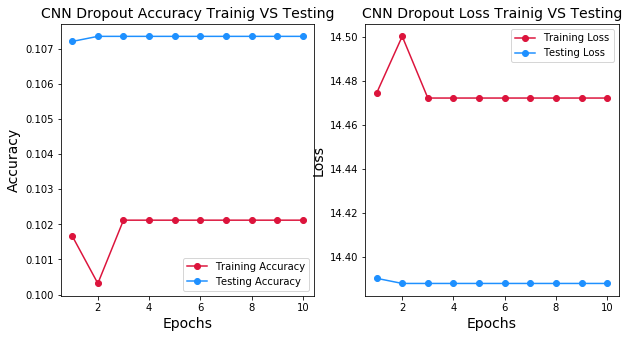

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


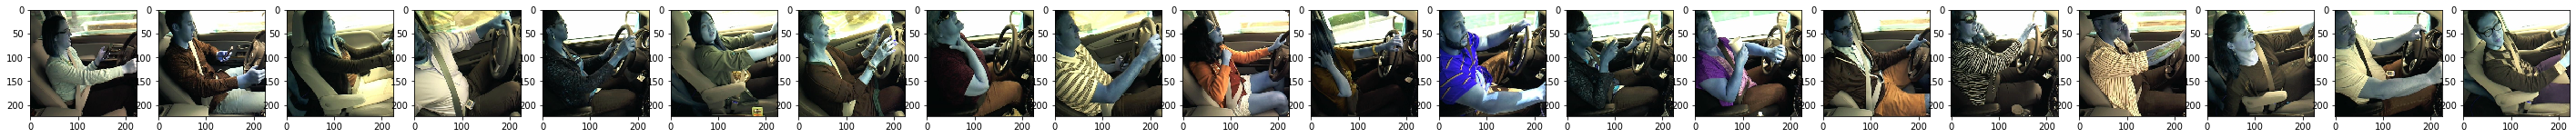

In [14]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('C:\\Users\\Sridhar\\Downloads\\state-farm-distracted-driver-detection\\imgs\\test')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('C:\\Users\\Sridhar\\Downloads\\state-farm-distracted-driver-detection\\imgs\\test\\'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show

In [15]:
test = []

for img in test_image:
    test.append(img)
    
vgg16_pretrained.load_weights('vgg_weights_aug_setval_sgd.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = vgg16_pretrained.predict(test)

In [16]:
prediction[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

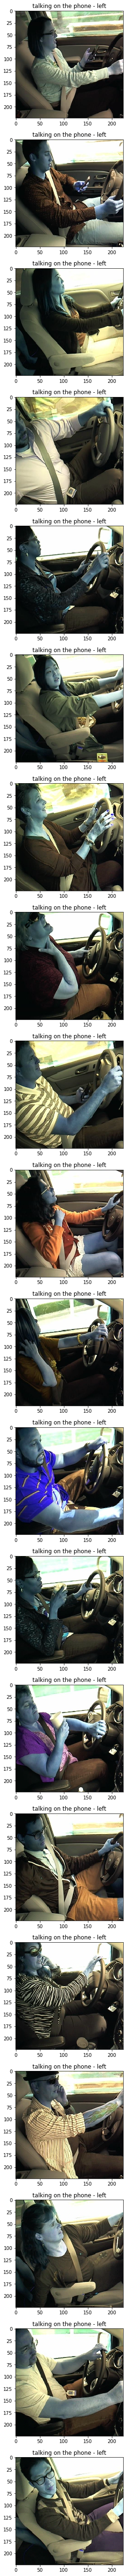

In [18]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show